#### Import Libs

In [1]:
import os
import re
import numpy as np
import simpy
import time
from numpy import random
from math import floor
from matplotlib import pyplot as plt
from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import randint

<hr>

## Ejercicio 1

####  File Utils

In [2]:
def read_file(folder, filename):
    filepath = os.path.join(folder, filename)
    file = open(filepath, 'r')
    page = file.read()
    return page

In [3]:
link_regex = '<a href=\"http://(.*?).html'

#### Page Rank

In [4]:
def open_pages(folder):
    filenames = os.listdir(folder)
    page_names = list(map(lambda filename: filename.split('.')[0], filenames))
    pages = []
    for filename in filenames:        
        page = read_file(folder, filename)
        pages.append(page)
    return (pages, page_names)

def markov_row(page, page_names):
    # n pages
    n = len(page_names)
    
    # search links in the page
    matchs = re.findall(link_regex, page)
    
    # build adjacency
    row = []
    if len(matchs) == 0:
        row = [1/n, 1/n, 1/n, 1/n, 1/n, 1/n]
    else:
        for page_name in page_names:
            n_matchs = 0
            for match in matchs:
                if page_name == match:
                    n_matchs += 1
            row.append(n_matchs / len(matchs))
    
    return row

def markov_matrix(pages, page_names):
    matrix = np.zeros(shape=(len(page_names), len(page_names)))
    for index, page in enumerate(pages):
        row = markov_row(page, page_names)
        matrix[index] = row
    return matrix

def distribucion_estacionaria(A):
    A = [1,0,0,0,0,0]
    for i in range(1000):
        A = np.dot(A,matrix)
    return A

#### Run

In [5]:
folder = 'paginas'
pages, page_names = open_pages(folder)
matrix = markov_matrix(pages, page_names)

print("Markov Matrix\n")
print(matrix)
print("\n")

page_rank = distribucion_estacionaria(matrix)
print("Page Rank\n")
aux = dict()

for i in range(len(page_names)):
    aux[page_names[i]]=page_rank[i]
    print(page_names[i][:13],"\t",page_rank[i])
page_rank = aux

# Sort key
def value_getter(item):
     return item[1]

sorted(aux.items(), key=value_getter,reverse=True)

Markov Matrix

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.         0.         0.66666667 0.         0.33333333 0.        ]
 [0.         0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.         0.         0.         1.        ]
 [0.25       0.         0.5        0.         0.         0.25      ]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]]


Page Rank

jenniferanist 	 0.10204081632653045
jonvoight 	 0.18367346938775478
angelinajolie 	 0.2857142857142853
robertdeniro 	 0.04081632653061218
bradpitt 	 0.24489795918367308
martinscorces 	 0.14285714285714263


[('angelinajolie', 0.2857142857142853),
 ('bradpitt', 0.24489795918367308),
 ('jonvoight', 0.18367346938775478),
 ('martinscorcese', 0.14285714285714263),
 ('jenniferaniston', 0.10204081632653045),
 ('robertdeniro', 0.04081632653061218)]

In [6]:
import string
folder = 'paginas'
filenames = os.listdir(folder)

indexes=dict()
for filename in filenames: 
    
    filepath = os.path.join(folder, filename)

    text = open(filepath, 'r')

    # Create an empty dictionary
    d = dict()
    # Loop through each line of the file
    for line in text:
        # Remove the leading spaces and newline character
        line = line.strip()

        # Convert the characters in line to
        # lowercase to avoid case mismatch
        line = line.lower()

        # Remove the punctuation marks from the line
        line = line.translate(line.maketrans("", "", string.punctuation))

        # Split the line into words
        words = line.split(" ")

        # Iterate over each word in line
        for word in words:
            # Check if the word is already in dictionary
            if word in d:
                # Increment count of word by 1
                d[word] = d[word] + 1
            else:
                # Add the word to dictionary with count 1
                d[word] = 1

                
    indexes[filename.split('.')[0]] = d

def calculate_scores(word):
    scores=dict()
    for key in list(indexes.keys()):
        if indexes[key].get(word) is None:
            # si no encuentra la palabra directamente le pone puntaje 0
            scores[key] = 0
        else:
            # ponderacion basica entre 
            scores[key]=0.5* indexes[key].get(word) + 0.5*page_rank[key]
    return sorted(scores.items(), key=lambda item: item[1],reverse=True)

scores=calculate_scores("film")
print(scores)

scores=calculate_scores("action")
print(scores)

scores=calculate_scores("actor")
print(scores)

[('martinscorcese', 3.071428571428571), ('angelinajolie', 1.6428571428571426), ('bradpitt', 1.6224489795918364), ('jonvoight', 0.5918367346938774), ('jenniferaniston', 0.5510204081632653), ('robertdeniro', 0.5204081632653061)]
[('jenniferaniston', 0), ('jonvoight', 0), ('angelinajolie', 0), ('robertdeniro', 0), ('bradpitt', 0), ('martinscorcese', 0)]
[('jonvoight', 2.0918367346938775), ('robertdeniro', 1.5204081632653061), ('bradpitt', 1.1224489795918364), ('martinscorcese', 1.0714285714285714), ('angelinajolie', 0.6428571428571427), ('jenniferaniston', 0)]


<hr>

## Ejercicio 3

<b>Web Service</b>. El cual consulta una <b>Base de Datos</b>.

Dos opciones: <br>
a) Utilizar dos bases de datos => <b>M/M/2</b> (dos canales de atencion) <br>
b) Utilizar una base de datos => <b>M/M/1</b> (un canal de atencion) <br>

Para ambos casos el tiempo entre arribos es 4 segundos:

In [7]:
# 1 arribo  ______ 4 segundos
# x arribos ______ 1 segundo
#
# x = (1 segundo * 1 arribo) / 4 segundos = 1/4 arribos en un segundo

$$
\lambda = \frac{1}{4}
$$

b)

Tiempo de servicio es 0.8 segundos, esta es la tasa de servicio.

$$
\mu = 0.8
$$

In [8]:
class Request:
    def __init__(self, id, timestamp):
        self.id = id
        self.timestamp = timestamp

class WebService:
    n = 10
    
    request_id = 0
    requests = []
    
    media_request = 0.25
    media_procesamiento = 0.8
    
    n_requests = 0
    n_procesadas = 0
    
    n_request_sin_procesar = 0
    
    total_elapsed = 0

    def __init__(self, env):
        self.env = env
        
    def get_media(self):
        return self.total_elapsed / self.n_procesadas
        
    def generador_requests(self):
        while self.n_procesadas < self.n:
            
            self.n_requests += 1
            self.n_request_sin_procesar += 1
            
            request = Request(self.n_requests, self.env.now)
            self.requests.append(request)
            
            print("proceso de requests | media: {} | n requess: {} | requests sin procesar: {}".format(self.media_request, self.n_requests, self.n_request_sin_procesar))
            
            tiempo = random.exponential(self.media_request)
            yield self.env.timeout(tiempo)
    
    def generador_procesamiento(self):
        while self.n_procesadas < self.n:
            if self.n_request_sin_procesar > 0:
       
                request = self.requests.pop()
                elapsed = self.env.now - request.timestamp
                print("elapsed: {}".format(elapsed))
                self.total_elapsed += elapsed
                
                self.n_procesadas += 1
                self.n_request_sin_procesar -= 1
                
                print("proceso de procesamiento | media: {} | n procesadas: {} | requests sin procesar: {}".format(self.media_procesamiento, self.n_procesadas, self.n_request_sin_procesar))
                
            tiempo = random.exponential(self.media_procesamiento)
            yield self.env.timeout(tiempo)

In [9]:
env = simpy.Environment()
web_service = WebService(env)
env.process(web_service.generador_requests())
env.process(web_service.generador_procesamiento())
env.run()

proceso de requests | media: 0.25 | n requess: 1 | requests sin procesar: 1
elapsed: 0
proceso de procesamiento | media: 0.8 | n procesadas: 1 | requests sin procesar: 0
proceso de requests | media: 0.25 | n requess: 2 | requests sin procesar: 1
elapsed: 0.08379710266515306
proceso de procesamiento | media: 0.8 | n procesadas: 2 | requests sin procesar: 0
proceso de requests | media: 0.25 | n requess: 3 | requests sin procesar: 1
proceso de requests | media: 0.25 | n requess: 4 | requests sin procesar: 2
elapsed: 0.4245384673661955
proceso de procesamiento | media: 0.8 | n procesadas: 3 | requests sin procesar: 1
proceso de requests | media: 0.25 | n requess: 5 | requests sin procesar: 2
proceso de requests | media: 0.25 | n requess: 6 | requests sin procesar: 3
proceso de requests | media: 0.25 | n requess: 7 | requests sin procesar: 4
proceso de requests | media: 0.25 | n requess: 8 | requests sin procesar: 5
proceso de requests | media: 0.25 | n requess: 9 | requests sin procesar: 6

Tiempo medio de espera entre que la solicitud llega y puede ser procesada.

In [10]:
web_service.get_media()

0.24468750785814292

## Ejercicio 4

In [11]:
CAP_MAX = 2000 # capacidad máxima de billetes

MEDIA_ARRIVO = 10 # media de la dist exp de tpo entre arrivo (10min)
LAMBDA_ARRIVO = 1 / MEDIA_ARRIVO

PROB_RET = 0.75 # probabilidad de que el cliente retire
MEDIA_RET = 1.5 # media de la dist exp de tpo de retiro (90s = 1.5min)
LAMBDA_RET = 1 / MEDIA_RET
MIN_RET = 3 # cant min de billetes que retira
MAX_RET = 50 # cant max de billetes que retira

MEDIA_DEP = 5 # media de la dist exp de tpo de deposito (5min)
LAMBDA_DEP = 1 / MEDIA_DEP
MIN_DEP = 10 # cant min de billetes que deposita
MAX_DEP = 110 # cant max de billetes que deposita

DIAS_SIM = 1000
MINUTOS_DIA = 24 * 60
TPO_SIM = DIAS_SIM * MINUTOS_DIA # tiempo de simulación (1000 dias)

In [12]:
# Definimos la simulación
#
# Referencias y materiales:
# - https://simpy.readthedocs.io/en/latest/simpy_intro/index.html
# - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html
# - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html#scipy.stats.uniform
# - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.randint.html
# - https://towardsdatascience.com/introduction-to-simulation-with-simpy-322606d4ba0c
# - https://simpy.readthedocs.io/en/latest/topical_guides/resources.html#containers

def operar(env, atm, nro_cl, media_op, cantidad, condicion, operacion):
    global caja, tot_abandonos, txs
    with atm.request() as req:
        tpo_entra_queue = env.now
        yield req;
        tpo_sale_queue = env.now
        tpo_espera = tpo_sale_queue - tpo_entra_queue

        tpo_op = expon.rvs(scale=media_op, size=1)[0]

        if condicion(caja, cantidad):
            caja = operacion(caja, cantidad)
            yield env.timeout(tpo_op)

            txs = np.vstack((txs, [caja, env.now, floor(env.now // MINUTOS_DIA)]))
        else:
            # no se da la condición para poder operar, abandona
            tot_abandonos += 1

        tpos_en_sist.append(tpo_espera + tpo_op)

def ret(env, atm, nro_cl):
    cantidad = randint.rvs(MIN_RET, MAX_RET, size=1)[0]
    condicion = lambda caja, cant: caja - cant >= 0
    operacion = lambda caja, cant: caja - cant
    return operar(env, atm, nro_cl, MEDIA_RET, cantidad, condicion, operacion)
    
def dep(env, atm, nro_cl):
    cantidad = randint.rvs(MIN_DEP, MAX_DEP, size=1)[0]
    condicion = lambda caja, cant: caja + cant < CAP_MAX
    operacion = lambda caja, cant: caja + cant
    return operar(env, atm, nro_cl, MEDIA_DEP, cantidad, condicion, operacion)

def arrivos_clientes(env, atm):
    global caja, tot_arrivos
    caja = CAP_MAX

    nro_cl = 0
    while True:
        # generamos un tpo de arrivo exponencial
        tpo_arrivo = expon.rvs(scale=MEDIA_ARRIVO, size=1)[0]
        yield env.timeout(tpo_arrivo)
        nro_cl += 1

        retira_dinero = uniform.rvs() < PROB_RET

        if retira_dinero:
            env.process(ret(env, atm, nro_cl))
        else:
            env.process(dep(env, atm, nro_cl))
    
        tot_arrivos = nro_cl

In [13]:
# a. simulación

# no uso Container de simpy porque las operaciones put/get no se ajustan al modelo
# y está garantizado que solo se usa un cajero, por lo que el recurso actua de lock
caja = CAP_MAX

# columnas: [monto de caja al finalizar tx; tpo al finalizar tx; dia de la tx]
COL_CAJA = 0
COL_FIN_TX = 1
COL_DIA_TX = 2
txs = np.empty((1, 3))

# tpos_en_sist contempla también el tiempo de aquellos que abandonan al no poder operar
tpos_en_sist = []

tot_abandonos = 0
tot_arrivos = 0

env = simpy.Environment()
atm = simpy.Resource(env, capacity=1)
env.process(arrivos_clientes(env, atm))
env.run(until=TPO_SIM)

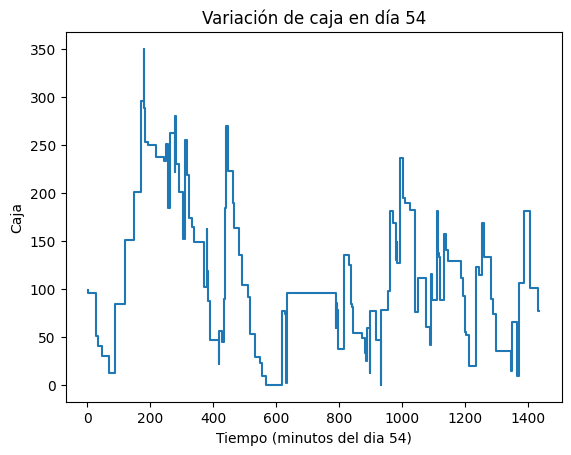

In [14]:
# b. Graficamos para un día particular, indexado desde 0
# https://stackoverflow.com/a/58079385
DIA = 54
txs_dia = txs[txs[:,COL_DIA_TX] == DIA, :]

plt.step(txs_dia[:,COL_FIN_TX] % MINUTOS_DIA, txs_dia[:,COL_CAJA])
plt.xlabel('Tiempo (minutos del dia %d)' % DIA)
plt.ylabel('Caja')
plt.title('Variación de caja en día %d' % DIA)
plt.show()

In [15]:
# c. tpo medio en el sistema
avg = np.average(np.array(tpos_en_sist))
avg_str = str(round(avg, 2))
print('El tiempo promedio en el sistema (espera + uso de cajero) es de %s minutos' % avg_str)

El tiempo promedio en el sistema (espera + uso de cajero) es de 3.37 minutos


In [16]:
# d. recomendación a la entidad
UMBRAL_TASA_ABANDONOS = 0.2
tasa_abandonos = tot_abandonos / tot_arrivos
tasa_abandonos_str = str(round(tasa_abandonos * 100, 2))

if tasa_abandonos < UMBRAL_TASA_ABANDONOS:
    print('La simulación resulta en una tasa de abandonos del %s%%. En consecuencia se sugiere la implementación del cambio' % tasa_abandonos_str)
else:
    print('La simulación resulta en una tasa de abandonos del %s%%. En consecuencia no se recomienda la implementación del cambio' % tasa_abandonos_str)

La simulación resulta en una tasa de abandonos del 15.38%. En consecuencia se sugiere la implementación del cambio


Nota: en casi todas las simulaciones realizadas se obtuvo resultados entre 13% y 15% de tasa de abandono, que es una mejora respecto al 20% inicial.